<a href="https://colab.research.google.com/github/EvaSamoilenko/ML-Experiments/blob/main/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данное исследование посвящено работе с текстовыми данными.

Собранные материалы по NLP:

1. [Вводная часть](https://colab.research.google.com/drive/1Fc9mAY-d-uA_x0naBQHYjbOSD7JyS0bf)

2. [Предобработка текста](https://colab.research.google.com/drive/1Lk4GcoS8KlXqjPXX6vK1teYbzaV5hNV8)

3. [Анализ и визуализация текстовых данных](https://colab.research.google.com/drive/1LoDu-ZvC4cKnfQTcgq_4Ya5gKmDyKg96)

4. [Векторизация](https://colab.research.google.com/drive/1n71YET2VbYIwyY0jYC5G1Zlkgl5ZInJ9)

5. [Другие задачи в области NLP](https://colab.research.google.com/drive/1u5IjpGisDXd_XH96lKTadJ8rKsg3VXD5)

In [ ]:
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import pandas as pd
import math
import numpy as np

from time import sleep
from google.colab import drive

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from collections import Counter, defaultdict

# Анализ текстовых данных

## Данные

Данные взяты с [OpenAlex](https://docs.openalex.org/).

Задача следующая: классификация коротких текстов по доменным областям знания, которым они принадлежат.

Для работы было собрано 10k англоязычных записей с OpenAlex. Для каждой записи сохранены поля `id`, `title`, `abstract`, `domain`. Запись сохраняется только при наличии всех полей.

[Страница документации OpenAlex](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/paging).

In [ ]:
domains = {
    "Life Sciences": 1,
    "Social Sciences": 2,
    "Physical Sciences": 3,
    "Health Sciences": 4
}

per_page = 200
total_needed = 10000
max_per_domain = total_needed // len(domains)

records = []

for domain_name, domain_id in domains.items():
    print(f"Сбор данных для {domain_name}")
    cursor = "*"
    collected = 0

    while collected < max_per_domain:
        url = "https://api.openalex.org/works"
        params = {
            "filter": f"primary_topic.domain.id:{domain_id},has_abstract:true",
            "per-page": per_page,
            "cursor": cursor,
            "mailto": "eva2like96@gmail.com"
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json()
        results = data.get("results", [])

        for item in results:
            # сохраните поля id, title, abstract, domain
            if item.get("id") and item.get("title") and item.get("abstract_inverted_index"):
                abstract_index = item["abstract_inverted_index"]
                abstract_words = sorted(
                    abstract_index.items(), key=lambda x: min(x[1])
                )
                abstract = " ".join(word for word, _ in abstract_words)

                records.append({
                    "id": item["id"],
                    "title": item["title"],
                    "abstract": abstract,
                    "domain": domain_name
                })
                collected += 1

                if collected >= max_per_domain:
                    break

        cursor = data["meta"]["next_cursor"]
        sleep(1)

print(f"Собрано {len(records)} записей")

df = pd.DataFrame(records)
df.head()

Сбор данных для Life Sciences
Сбор данных для Social Sciences
Сбор данных для Physical Sciences
Сбор данных для Health Sciences


KeyboardInterrupt: 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv("/content/drive/MyDrive/openalex.csv", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/openalex.csv")

Изучение собранных данных:

* общее количество записей;

* количество уникальных значений (какие и сколько) для доменных областей;

* распределение количества символов и количества слов для `title` и `abstract`.

In [ ]:
# Общее количество записей
total_records = len(df)
print(f"Общее количество записей: {total_records}")

# Количество уникальных доменных областей и сколько в каждой
domain_counts = df['domain'].value_counts()
print("\nРаспределение по доменам:")
print(domain_counts)

# Длина title и abstract в символах и словах
df['title_char_len'] = df['title'].apply(len)
df['title_word_len'] = df['title'].apply(lambda x: len(x.split()))
df['abstract_char_len'] = df['abstract'].apply(len)
df['abstract_word_len'] = df['abstract'].apply(lambda x: len(x.split()))

print("\nСтатистика по количеству символов и слов:")

print("\nTitle (символы):")
print(df['title_char_len'].describe())

print("\nTitle (слова):")
print(df['title_word_len'].describe())

print("\nAbstract (символы):")
print(df['abstract_char_len'].describe())

print("\nAbstract (слова):")
print(df['abstract_word_len'].describe())

Общее количество записей: 10000

Распределение по доменам:
domain
Life Sciences        2500
Social Sciences      2500
Physical Sciences    2500
Health Sciences      2500
Name: count, dtype: int64

Статистика по количеству символов и слов:

Title (символы):
count    10000.000000
mean        68.336100
std         35.043064
min          3.000000
25%         44.000000
50%         64.000000
75%         85.000000
max        499.000000
Name: title_char_len, dtype: float64

Title (слова):
count    10000.000000
mean         9.064400
std          4.669522
min          1.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         67.000000
Name: title_word_len, dtype: float64

Abstract (символы):
count    10000.000000
mean       882.027200
std        896.851783
min          8.000000
25%        517.000000
50%        765.000000
75%       1089.250000
max      17623.000000
Name: abstract_char_len, dtype: float64

Abstract (слова):
count    10000.000000
mean       112.240100
s

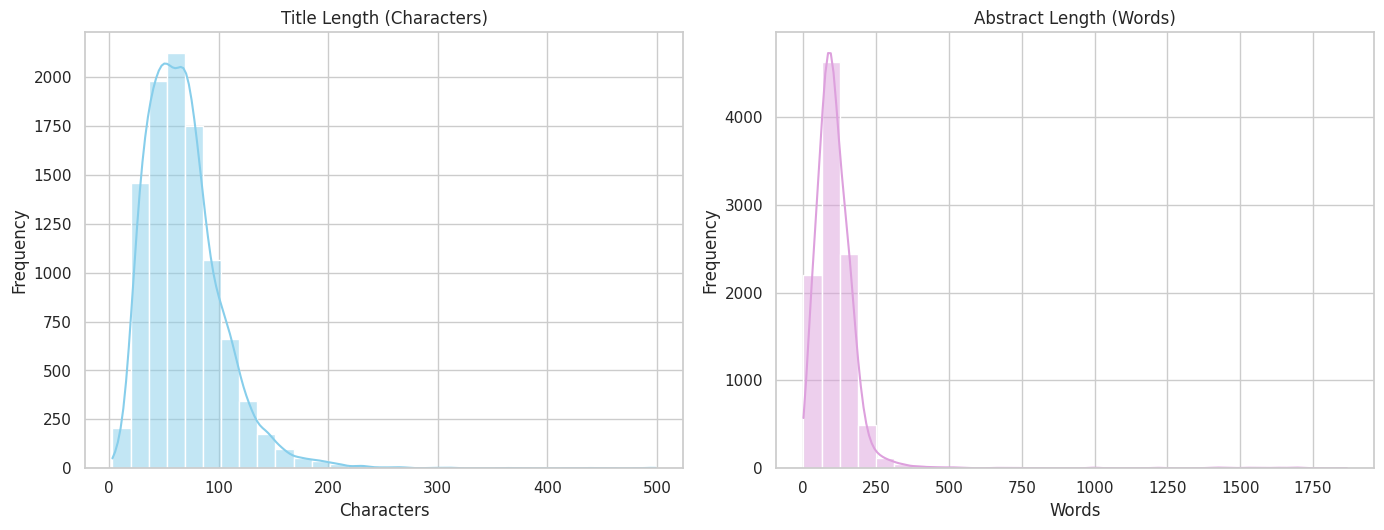

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Распределение длины title в символах
plt.subplot(2, 2, 1)
sns.histplot(df['title_char_len'], bins=30, kde=True, color='skyblue')
plt.title('Title Length (Characters)')
plt.xlabel('Characters')
plt.ylabel('Frequency')

# Распределение длины abstract в словах
plt.subplot(2, 2, 2)
sns.histplot(df['abstract_word_len'], bins=30, kde=True, color='plum')
plt.title('Abstract Length (Words)')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Функция для предобработки текстовых данных включает следующие шаги:

1. приведение текста к нижнему регистру;

2. удаление пунктуации и чисел;

3. лемматизация;

4. удаление стоп-слов;

5. удаление лишних пробельных символов.

In [ ]:
!pip install nltk spacy
!python -m nltk.downloader stopwords
!python -m spacy download en_core_web_sm

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 104.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.lemma_.isalpha()]

    return ' '.join(tokens)

df['title_abstract'] = df['title'] + ' ' + df['abstract']

df['title_abstract_preprocessed'] = df['title_abstract'].apply(preprocess_text)

df = df[['id', 'title', 'abstract', 'domain', 'title_abstract', 'title_abstract_preprocessed']]

df.head()

In [ ]:
df.to_csv("/content/drive/MyDrive/openalex_preprocessed.csv", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/openalex_preprocessed.csv")

В качестве алгоритма классификации будем использовать Наивный Байес (`MultinomialNB`) и `LinearSVC` с фиксированным `random_state`=42.

Для оценки разделим данные в соотношении 80:20 до проведения любой векторизации.

**Общее правило**, чтобы понять, можно применять обработку до разделения или только после - если предобработка работает с каждой записью независимо, то можно пременить её до разделения. Иначе, если при обработке одной записи используется какая-либо информация из других записей (среднее, уникальные значения, общее кол-во и так далее), применять её рекомендуется только после разделения.

При оценке использую `classification_report` и `confusion_matrix`.

In [ ]:
clf1 = MultinomialNB()
clf2 = LinearSVC(random_state=42)

=== MultinomialNB ===
                   precision    recall  f1-score   support

  Health Sciences       0.81      0.74      0.78       500
    Life Sciences       0.80      0.75      0.77       500
Physical Sciences       0.85      0.86      0.85       500
  Social Sciences       0.80      0.91      0.85       500

         accuracy                           0.81      2000
        macro avg       0.81      0.81      0.81      2000
     weighted avg       0.81      0.81      0.81      2000

=== LinearSVC ===
                   precision    recall  f1-score   support

  Health Sciences       0.86      0.80      0.83       500
    Life Sciences       0.83      0.80      0.81       500
Physical Sciences       0.85      0.87      0.86       500
  Social Sciences       0.84      0.91      0.88       500

         accuracy                           0.85      2000
        macro avg       0.85      0.85      0.84      2000
     weighted avg       0.85      0.85      0.84      2000



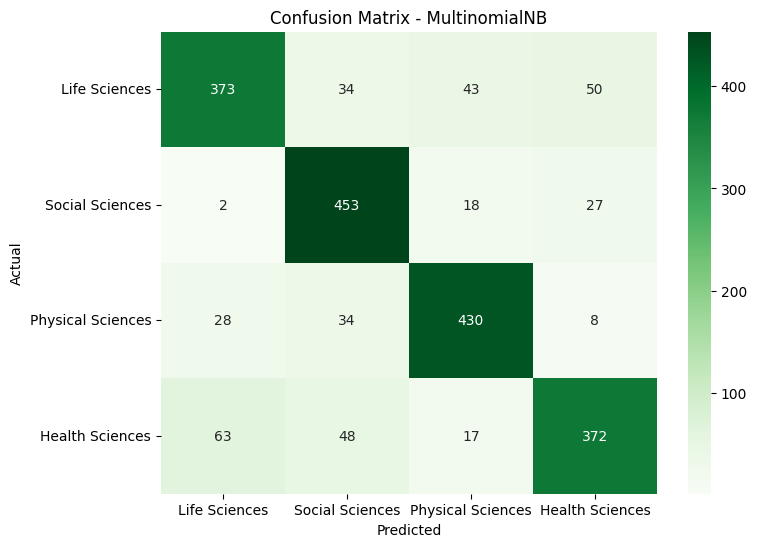

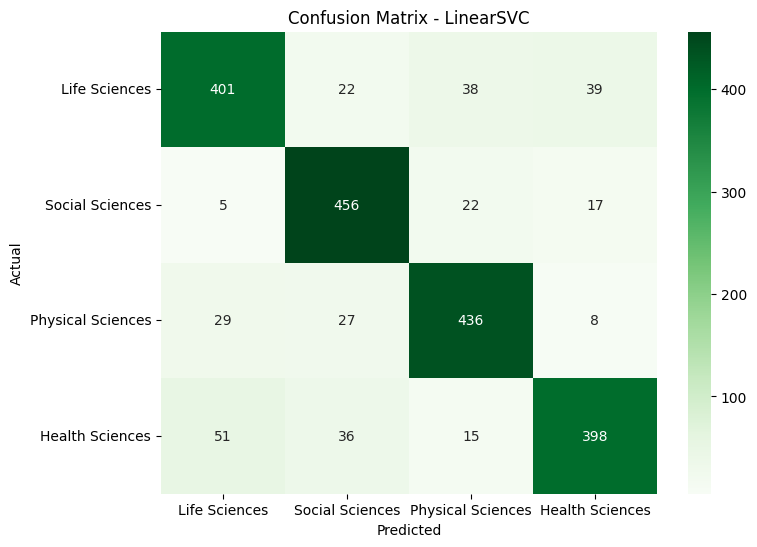

In [ ]:
X = df['title_abstract_preprocessed']
y = df['domain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Векторизация Tfidf
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Обучение
clf1.fit(X_train_vec, y_train)
clf2.fit(X_train_vec, y_train)

# Предсказания
y_pred_nb = clf1.predict(X_test_vec)
y_pred_svc = clf2.predict(X_test_vec)

# Оценка качества
print("=== MultinomialNB ===")
print(classification_report(y_test, y_pred_nb))

print("=== LinearSVC ===")
print(classification_report(y_test, y_pred_svc))

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=y.unique())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=y.unique(), yticklabels=y.unique())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_nb, "Confusion Matrix - MultinomialNB")
plot_confusion_matrix(y_test, y_pred_svc, "Confusion Matrix - LinearSVC")

**1. MultinomialNB**:
- *Life Sciences* (правильных — 373): 50 перепутаны с Health Sciences, 43 — с Physical Sciences, 34 — с Social Sciences.

  Модель часто путает Life Sciences с близкими по лексике научными направлениями, особенно Health.

- *Health Sciences* (правильных — 372): целых 63 ошибок в сторону Life Sciences, ещё 48 — Social.

  Явно наблюдается семантическое пересечение с Life Sciences.

- *Social Sciences* (правильных — 453): очень хорошая точность, всего 47 ошибок.

  Минимальное смешение с другими доменами.

- *Physical Sciences* (правильных — 430): ошибки в сторону Life (28) и Social (34).

**2. LinearSVC**:
- *Life Sciences* (правильных — 401, на 28 больше, чем у Naive Bayes): ошибки уменьшились, особенно по сравнению с Health (с 50 до 39)

  Лучше разделяет Health и Life.

- *Health Sciences* (правильных — 398 против 372 у NB): снижение ошибок на 26, особенно в пользу Life и Social.

- *Social Sciences* (правильных — 456): почти идентичный результат как у NB (453) → обе модели справляются отлично.

- *Physical Sciences* (правильных — 436): улучшено — меньше ошибок в сторону Life и Social.

**LinearSVC выигрывает**: лучше различает классы, особенно в бою Health vs Life.

У MultinomialNB трудности с разграничением доменов, связанных с медициной и биологией.

Social Sciences — наименее проблемный класс для обеих моделей (наиболее отличающийся текстово).

## Bag of Words

"Мешок слов" (Bag of Words, BoW) — это самый простой подход к векторизации текста.

Порядок слов не учитывается, а вся информация об анализируемом тексте сосредоточена в частоте встречаемости слов.
```
docs = [
  {'word1': 2, 'word2': 0, 'word3': 8, ...},
  {'word1': 1, 'word2': 0, 'word3': 2, ...},
  ...
  ]

len(docs[i].keys()) = общее кол-во слов ('word1', 'word2', 'word3', ...) в корпусе
docs[i] - представление i-того документа
```

Основные шаги алгоритма:

1. токенизация;

2. fit: построение словаря: создание словаря из всех уникальных слов, встречающихся в корпусе;

3. transform: подсчет частоты: для каждого слова из словаря подсчитывается, сколько раз оно встречается в тексте.

Работать будем только со словами. Параметр max_features отвечает за фиксированную длину вектора.

In [ ]:
class BagOfWords:
    """
    Bag of Words модель для векторизации текстовых данных.

    Параметры:
        ngram_range (tuple): Диапазон n-грамм для создания признаков.
        max_features (int): Максимальное количество признаков для использования.

    Атрибуты:
        ngram_range (tuple): Диапазон n-грамм для создания признаков.
        max_features (int): Максимальное количество признаков для использования.
        vocabulary (dict): Словарь, сопоставляющий токены частоте их встречаемости.
    """

    def __init__(self, ngram_range=(1, 1), max_features=None):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vocabulary = {}

    def fit(self, documents):
        """
        Создает словарь на основе предоставленных документов.

        Параметры:
            documents (list): Список текстовых документов.
        """
        freq = Counter()
        for doc in documents:
            tokens = self.tokenize(doc)
            freq.update(tokens)

        # Сохраняем top-N токенов, если max_features указан
        most_common = freq.most_common(self.max_features)
        self.vocabulary = {word: idx for idx, (word, _) in enumerate(most_common)}

    def transform(self, documents):
        """
        Преобразует текстовые документы в векторное представление с использованием созданного словаря.

        Параметры:
            documents (list): Список текстовых документов.

        Возвращает:
            list: Векторное представление документов.
        """
        if not self.vocabulary:
            raise ValueError("The vocabulary has not been created. Call fit method first.")

        vectors = []
        for doc in documents:
            tokens = self.tokenize(doc)
            vec = [0] * len(self.vocabulary)
            for token in tokens:
                if token in self.vocabulary:
                    vec[self.vocabulary[token]] += 1
            vectors.append(vec)
        return vectors

    def fit_transform(self, documents):
        """
        Обучает модель на предоставленных документах и возвращает их векторное представление.

        Параметры:
            documents (list): Список текстовых документов.

        Возвращает:
            list: Векторное представление документов.
        """
        self.fit(documents)
        return self.transform(documents)

    def tokenize(self, text):
        """
        Разбивает текст на токены.

        Параметры:
            text (str): Текст для токенизации.

        Возвращает:
            list: Список токенов.
        """
        tokens = re.findall(r'\b\w+\b', text.lower())
        ngrams = []
        for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
            ngrams += [' '.join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
        return ngrams

In [ ]:
bow = BagOfWords(ngram_range=(1, 2), max_features=15)

test_sentences = [
    "BoW transforms text into a frequency vector based on words occurrence",
    "in BoW each word's count creates a unique feature",
    "BoW ignores word order focusing on word occurrence frequency",
]

vectors = bow.fit_transform(test_sentences)
pd.DataFrame(vectors, columns=list(bow.vocabulary.keys()))

,bow,word,a,frequency,on,occurrence,transforms,text,into,vector,based,words,bow transforms,transforms text,text into
0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,0,1,1,1,0,0,0,0,0,0,0,0,0


Векторизуем тексты с помощью этого алгоритма. Обучаем классификатор и оцениваем скорость работы и качество классификации по доменным областям (domain).

In [ ]:
X = df["title_abstract_preprocessed"].tolist()
y = df["domain"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
params = [
    {"ngram_range": (1, 1), "max_features": 1000},
    {"ngram_range": (1, 2), "max_features": 5000},
    {"ngram_range": (1, 2), "max_features": 10000},
]

In [ ]:
results = []

for config in params:
    print(f"\n=== Config: {config} ===")

    bow = BagOfWords(**config)

    start = time.time()
    X_train_vec = bow.fit_transform(X_train)
    X_test_vec = bow.transform(X_test)
    elapsed = time.time() - start

    print(f"Vectorization Time: {elapsed:.2f} seconds")

    # MultinomialNB
    start_mnb = time.time()
    mnb = MultinomialNB()
    mnb.fit(X_train_vec, y_train)
    mnb_preds = mnb.predict(X_test_vec)
    mnb_time = time.time() - start_mnb

    print(f"\n--- MultinomialNB ---")
    print(f"Training + Prediction Time: {mnb_time:.2f} seconds")
    print(classification_report(y_test, mnb_preds))
    mnb_report = classification_report(y_test, mnb_preds, output_dict=True)

    # LinearSVC
    start_lsvc = time.time()
    lsvc = LinearSVC()
    lsvc.fit(X_train_vec, y_train)
    lsvc_preds = lsvc.predict(X_test_vec)
    lsvc_time = time.time() - start_lsvc

    print(f"\n--- LinearSVC ---")
    print(f"Training + Prediction Time: {lsvc_time:.2f} seconds")
    print(classification_report(y_test, lsvc_preds))
    lsvc_report = classification_report(y_test, lsvc_preds, output_dict=True)

    results.append({
        'config': config,
        'vocab_size': len(bow.vocabulary),
        'vectorization_time': elapsed,
        'mnb_time': mnb_time,
        'mnb_accuracy': mnb_report['accuracy'],
        'lsvc_time': lsvc_time,
        'lsvc_accuracy': lsvc_report['accuracy'],
    })


=== Config: {'ngram_range': (1, 1), 'max_features': 1000} ===
Vectorization Time: 2.78 seconds

--- MultinomialNB ---
Training + Prediction Time: 1.70 seconds
                   precision    recall  f1-score   support

  Health Sciences       0.80      0.68      0.74       496
    Life Sciences       0.73      0.69      0.71       512
Physical Sciences       0.76      0.82      0.79       492
  Social Sciences       0.77      0.86      0.82       500

         accuracy                           0.76      2000
        macro avg       0.76      0.76      0.76      2000
     weighted avg       0.76      0.76      0.76      2000


--- LinearSVC ---
Training + Prediction Time: 1.70 seconds
                   precision    recall  f1-score   support

  Health Sciences       0.73      0.70      0.72       496
    Life Sciences       0.73      0.69      0.71       512
Physical Sciences       0.74      0.76      0.75       492
  Social Sciences       0.74      0.79      0.76       500

        

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- LinearSVC ---
Training + Prediction Time: 17.00 seconds
                   precision    recall  f1-score   support

  Health Sciences       0.75      0.74      0.75       496
    Life Sciences       0.71      0.72      0.72       512
Physical Sciences       0.76      0.77      0.76       492
  Social Sciences       0.77      0.77      0.77       500

         accuracy                           0.75      2000
        macro avg       0.75      0.75      0.75      2000
     weighted avg       0.75      0.75      0.75      2000


=== Config: {'ngram_range': (1, 2), 'max_features': 10000} ===
Vectorization Time: 5.24 seconds

--- MultinomialNB ---
Training + Prediction Time: 13.51 seconds
                   precision    recall  f1-score   support

  Health Sciences       0.84      0.70      0.77       496
    Life Sciences       0.77      0.74      0.76       512
Physical Sciences       0.83      0.83      0.83       492
  Social Sciences       0.76      0.92      0.83       500

     

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- LinearSVC ---
Training + Prediction Time: 10.01 seconds
                   precision    recall  f1-score   support

  Health Sciences       0.78      0.76      0.77       496
    Life Sciences       0.74      0.72      0.73       512
Physical Sciences       0.76      0.79      0.78       492
  Social Sciences       0.78      0.79      0.78       500

         accuracy                           0.77      2000
        macro avg       0.77      0.77      0.77      2000
     weighted avg       0.77      0.77      0.77      2000



In [ ]:
results_df = pd.DataFrame(results)
print("=== Summary of results ===")
results_df[['config', 'vocab_size', 'mnb_time', 'mnb_accuracy', 'lsvc_time', 'lsvc_accuracy']]

=== Summary of results ===


,config,vocab_size,mnb_time,mnb_accuracy,lsvc_time,lsvc_accuracy
0,"{'ngram_range': (1, 1), 'max_features': 1000}",1000,1.704812,0.7635,1.696985,0.7365
1,"{'ngram_range': (1, 2), 'max_features': 5000}",5000,6.415969,0.7905,16.996259,0.7490
2,"{'ngram_range': (1, 2), 'max_features': 10000}",10000,13.514054,0.7975,10.012197,0.7660


**N-граммы (1,2):**
Добавление биграмм даёт заметное улучшение по всем метрикам для обеих моделей.

Это особенно важно для *LinearSVC*, который может лучше использовать контекст.

**Размер словаря (max_features):**
Рост до 10,000 даёт наибольшую точность, но с убывающей отдачей: прирост метрик становится всё меньше.

Вероятно, дальше рост словаря даст лишь небольшой прирост при значительно большей вычислительной нагрузке.

**Сравнение моделей:**

*MultinomialNB* показывает лучшие результаты на меньших объемах признаков, вероятно, за счёт своей устойчивости к шуму.

*LinearSVC* догоняет по качеству при большем объёме данных (10к признаков), но при этом работает медленнее.

Посмотрим на готовую реализацию CountVectorizer из sklearn. Сопоставимые ли результаты получаются?

In [ ]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': [1000, 5000, 10000]
}

pipe_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

pipe_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC(random_state=42))
])

In [ ]:
grid_nb = GridSearchCV(pipe_nb, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_nb.fit(X_train, y_train)

grid_svc = GridSearchCV(pipe_svc, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_svc.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'vect__max_features': [1000, 5000, 10000],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

In [ ]:
print("=== Best params MultinomialNB ===")
print(grid_nb.best_params_)
y_pred_nb = grid_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

print("=== Best params LinearSVC ===")
print(grid_svc.best_params_)
y_pred_svc = grid_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

=== Best params MultinomialNB ===
{'vect__max_features': 10000, 'vect__ngram_range': (1, 1)}
                   precision    recall  f1-score   support

  Health Sciences       0.84      0.72      0.77       496
    Life Sciences       0.78      0.74      0.76       512
Physical Sciences       0.83      0.84      0.83       492
  Social Sciences       0.78      0.91      0.84       500

         accuracy                           0.80      2000
        macro avg       0.81      0.80      0.80      2000
     weighted avg       0.81      0.80      0.80      2000

=== Best params LinearSVC ===
{'vect__max_features': 10000, 'vect__ngram_range': (1, 2)}
                   precision    recall  f1-score   support

  Health Sciences       0.77      0.76      0.76       496
    Life Sciences       0.74      0.72      0.73       512
Physical Sciences       0.78      0.79      0.79       492
  Social Sciences       0.77      0.79      0.78       500

         accuracy                           0.

Для *LinearSVC* выводы всё те же: ей способствует большой объём данных и расширенный контекст.

Тем не менее, с тем же количеством слов, но меньшим контекстом, *MultinomialNB* всё же превосходит по accuracy на 0.04.

### Keywords

С помощью `CountVectorizer` выведем топ-20 ключевых слов для каждого домена (то есть таких, которые превалируют именно в конкретном домене) и общие топ-20 слов по всем доменам, чтобы была ещё одна метрика сравнения векторизаторов.

In [ ]:
df.head()

,id,title,abstract,domain,title_abstract,title_abstract_preprocessed
0,https://openalex.org/W1775749144,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT,Since 1922 when Wu proposed the use of Folin p...,Life Sciences,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAG...,protein measurement folin phenol reagent since...
1,https://openalex.org/W2144634347,Molecular Cloning: A Laboratory Manual,Molecular Cloning has served as the foundation...,Life Sciences,Molecular Cloning: A Laboratory Manual Molecul...,molecular clone laboratory manual molecular cl...
2,https://openalex.org/W2179438025,Moderated estimation of fold change and disper...,In comparative high-throughput sequencing assa...,Life Sciences,Moderated estimation of fold change and disper...,moderated estimation fold change dispersion rn...
3,https://openalex.org/W2158714788,Gapped BLAST and PSI-BLAST: a new generation o...,The BLAST programs are widely used tools for s...,Life Sciences,Gapped BLAST and PSI-BLAST: a new generation o...,gap blast psiblast new generation protein data...
4,https://openalex.org/W2106882534,CLUSTAL W: improving the sensitivity of progre...,The sensitivity of the commonly used progressi...,Life Sciences,CLUSTAL W: improving the sensitivity of progre...,clustal w improve sensitivity progressive mult...


In [ ]:
texts = df["title_abstract_preprocessed"]
domains = df["domain"]

vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(texts)

X_array = X.toarray()
words = vectorizer.get_feature_names_out()
word_df = pd.DataFrame(X_array, columns=words)
word_df["domain"] = domains.values

top_overall = word_df.drop(columns="domain").sum().sort_values(ascending=False).head(20)
print("=== Топ-20 слов по всем доменам ===")
print(top_overall)

domains_unique = word_df["domain"].unique()

for domain in domains_unique:
    print(f"\n--- Топ-20 слов для домена {domain} ---")

    domain_texts = df[df['domain'] == domain]['title_abstract_preprocessed']

    domain_vectorizer = CountVectorizer(max_features=20, stop_words='english')
    X_domain = domain_vectorizer.fit_transform(domain_texts)

    domain_words = domain_vectorizer.get_feature_names_out()
    word_counts = X_domain.sum(axis=0).A1

    word_freq = sorted(zip(domain_words, word_counts), key=lambda x: -x[1])

    for word, count in word_freq[:20]:
        print(f"{word}: {count}")

=== Топ-20 слов по всем доменам ===
use         5971
study       3945
model       3192
method      3160
analysis    3131
datum       3052
include     2781
result      2712
provide     2519
new         2485
disease     2358
research    2354
patient     2250
present     2132
cell        2060
theory      2047
review      1863
increase    1840
function    1812
process     1761
dtype: int64

--- Топ-20 слов для домена Life Sciences ---
use: 1585
cell: 1240
gene: 1213
sequence: 1172
protein: 1056
analysis: 1031
datum: 935
study: 860
method: 841
provide: 767
include: 734
human: 711
result: 689
function: 663
new: 658
genome: 602
model: 602
disease: 549
present: 517
structure: 515

--- Топ-20 слов для домена Social Sciences ---
use: 1166
study: 1152
theory: 1148
research: 1086
model: 963
social: 820
analysis: 793
work: 627
process: 617
method: 603
new: 603
change: 566
datum: 545
provide: 529
result: 520
include: 499
development: 497
review: 489
present: 488
effect: 473

--- Топ-20 слов для доме

## TF-IDF

TF-IDF представляет собой числовую статистику, отражающую важность слова в документе относительно коллекции документов (корпуса). Всё еще считается частота слов, но теперь это делается более по-умному.

Оценка TF-IDF вычисляется с использованием двух основных компонент: частоты термина (TF) и обратной частоты документа (IDF).

1. **TF**
   
   Измеряет, насколько часто термин (слово) встречается в документе. Рассчитывается как отношение числа раз, когда термин появляется в документе, к общему числу терминов в этом документе.
   
   $$ \text{TF}(t, d) = \frac{\text{Количество раз, когда термин } t \text{ появляется в документе } d}{\text{Общее количество терминов в документе } d} $$

2. **IDF**
   
   Измеряет важность термина по всему корпусу. Она рассчитывается как логарифм отношения общего числа документов к числу документов, содержащих термин, плюс единица для избежания деления на ноль.

   $$ \text{IDF}(t, D) = \log\left(\frac{\text{Общее количество документов в корпусе } N}{\text{Количество документов, содержащих термин } t + 1} \right) $$

   Здесь \(N\) - общее количество документов в корпусе.
   Логарифм нужен для сглаживания.

   **P.S.** В sklearn используется формула $$ \text{IDF}(t, D) = \log\left(\frac{\text{Общее количество документов в корпусе } N + 1}{\text{Количество документов, содержащих термин } t + 1} \right) + 1 $$


3. **Оценка TF-IDF:**
   
   $$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$

   Эта оценка присваивает более высокий вес терминам, часто встречающимся в конкретном документе, но относительно редким в общей коллекции документов.

Новая задача - реализовать класс для векторизации с помощью TF-IDF подхода. Будем использовать разбиение только по словам. При отборе `max_features` ориентируйтесь на term frequency.

In [ ]:
class TFIDF:
    """
    TF-IDF модель для векторизации текстовых данных.

    Параметры:
        ngram_range (tuple): Диапазон n-грамм для создания признаков.
        max_features (int): Максимальное количество признаков для использования.

    Атрибуты:
        ngram_range (tuple): Диапазон n-грамм для создания признаков.
        max_features (int): Максимальное количество признаков для использования.
        vocabulary (dict): Словарь, сопоставляющий токены их tf-idf значениям.
    """

    def __init__(self, ngram_range=(1, 1), max_features=None):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vocabulary = {}  # слово → индекс
        self.idf = {}  # слово → IDF значение

    def fit(self, documents):
        """
        Создает словарь на основе предоставленных документов.

        Параметры:
            documents (list): Список текстовых документов.
        """
        doc_count = len(documents)
        tf_counts = Counter()
        df_counts = defaultdict(int)  # document frequency

        tokenized_docs = []

        for doc in documents:
            tokens = self.tokenize(doc)
            tokenized_docs.append(tokens)
            tf_counts.update(tokens)  # сколько раз слово встречается вообще
            for token in set(tokens):
                df_counts[token] += 1  # в скольких разных документах оно есть

        # oтбор top max_features по term frequency
        most_common_tokens = [token for token, _ in tf_counts.most_common(self.max_features)]
        self.vocabulary = {token: idx for idx, token in enumerate(most_common_tokens)}

        # Расчёт IDF
        self.idf = {
            token: math.log((doc_count + 1) / (df_counts[token] + 1)) + 1
            for token in self.vocabulary
        }

        self._tokenized_docs = tokenized_docs  # для возможного переиспользования

    def transform(self, documents):
        """
        Преобразует текстовые документы в векторное представление с использованием созданного словаря.

        Параметры:
            documents (list): Список текстовых документов.

        Возвращает:
            list: Векторное представление документов.
        """
        if not len(self.vocabulary):
            raise ValueError("The vocabulary has not been created. Call fit method first.")

        tfidf_vectors = []

        for doc in documents:
            tokens = self.tokenize(doc)
            tf = Counter(tokens)

            vector = [0.0] * len(self.vocabulary)
            for token in tf:
                if token in self.vocabulary:
                    idx = self.vocabulary[token]
                    tfidf = tf[token] * self.idf[token]
                    vector[idx] = tfidf
            tfidf_vectors.append(vector)

        return tfidf_vectors

    def fit_transform(self, documents):
        """
        Обучает модель на предоставленных документах и возвращает их векторное представление.

        Параметры:
            documents (list): Список текстовых документов.

        Возвращает:
            list: Векторное представление документов.
        """
        self.fit(documents)
        return self.transform(documents)

    def tokenize(self, text):
        """
        Разбивает текст на токены.

        Параметры:
            text (str): Текст для токенизации.

        Возвращает:
            list: Список токенов.
        """
        tokens = re.findall(r'\b[a-z]+\b', text.lower())  # только слова
        ngrams = []
        for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
            ngrams += [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        return ngrams

In [ ]:
tfidf = TFIDF(ngram_range=(1, 2), max_features=15)

test_sentences = [
    "tf-idf measures word importance relative to its frequency in a document",
    "tf-idf considers word uniqueness across all documents in the corpus",
    "it identifies significant words common in a document yet rare across all documents"
]

vectors = tfidf.fit_transform(test_sentences)
pd.DataFrame(vectors, columns=list(tfidf.vocabulary.keys()))

,in,tf,idf,word,a,document,tf idf,in a,a document,across,all,documents,across all,all documents,measures
0,1.0,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,0.000000,0.000000,0.000000,0.000000,0.000000,1.693147
1,1.0,1.287682,1.287682,1.287682,0.000000,0.000000,1.287682,0.000000,0.000000,1.287682,1.287682,1.287682,1.287682,1.287682,0.000000
2,1.0,0.000000,0.000000,0.000000,1.287682,1.287682,0.000000,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,0.000000


Векторизуем тексты с помощью нового алгоритма.

In [ ]:
X_raw = df["title_abstract_preprocessed"].tolist()
y = df["domain"].tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

configs = [
    {"ngram_range": (1, 1), "max_features": 1000},
    {"ngram_range": (1, 2), "max_features": 5000},
    {"ngram_range": (1, 2), "max_features": 10000}
]

results = []

In [ ]:
for config in configs:
    tfidf = TFIDF(ngram_range=config["ngram_range"], max_features=config["max_features"])

    start = time.time()
    X_train = tfidf.fit_transform(X_train_raw)
    X_test = tfidf.transform(X_test_raw)
    vectorize_time = time.time() - start

    # Модели
    clf1 = MultinomialNB()
    clf2 = LinearSVC(random_state=42)

    # MultinomialNB
    start = time.time()
    clf1.fit(X_train, y_train)
    pred1 = clf1.predict(X_test)
    train_time_1 = time.time() - start
    acc1 = accuracy_score(y_test, pred1)
    f1_1 = classification_report(y_test, pred1, output_dict=True)["weighted avg"]["f1-score"]

    # LinearSVC
    start = time.time()
    clf2.fit(X_train, y_train)
    pred2 = clf2.predict(X_test)
    train_time_2 = time.time() - start
    acc2 = accuracy_score(y_test, pred2)
    f1_2 = classification_report(y_test, pred2, output_dict=True)["weighted avg"]["f1-score"]

    results.append({
        "config": config,
        "vocab_size": len(tfidf.vocabulary),
        "vectorize_time": round(vectorize_time, 2),
        "mnb_accuracy": round(acc1, 4),
        "lsvc_accuracy": round(acc2, 4),
        "mnb_time": round(train_time_1, 2),
        "lsvc_time": round(train_time_2, 2),
    })

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
results_df = pd.DataFrame(results)
print("=== Summary of results ===")
print(results_df)

=== Summary of results ===
                                           config  vocab_size  vectorize_time  \
0   {'ngram_range': (1, 1), 'max_features': 1000}        1000            7.17   
1   {'ngram_range': (1, 2), 'max_features': 5000}        5000            5.92   
2  {'ngram_range': (1, 2), 'max_features': 10000}       10000            4.95   

   mnb_accuracy  lsvc_accuracy  mnb_time  lsvc_time  
0        0.7660         0.7280      1.14       2.07  
1        0.7965         0.7515      2.96      15.61  
2        0.7985         0.7580      7.33      14.41  


- Качество жизни всех растёт с увеличением max_features

- *LinearSVC* намного дольше обучается

- ngram_range = (1, 2) даёт прирост в качестве, но увеличивает размерность и время

Сравнение с готовой реализацией TfIdfVectorizer из sklearn.

In [ ]:
X = df["title_abstract_preprocessed"].tolist()
y = df["domain"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())  # LinearSVC позже
])

params = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [1000, 5000, 10000],
}

In [ ]:
grid_nb = GridSearchCV(pipe, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train, y_train)

print("Best NB params:", grid_nb.best_params_)
print("Best NB score on train:", grid_nb.best_score_)

y_pred_nb = grid_nb.predict(X_test)
print("\n=== MultinomialNB Results ===")
print(classification_report(y_test, y_pred_nb))

Best NB params: {'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}
Best NB score on train: 0.8068748064406428

=== MultinomialNB Results ===
                   precision    recall  f1-score   support

  Health Sciences       0.83      0.72      0.78       500
    Life Sciences       0.79      0.74      0.76       500
Physical Sciences       0.83      0.86      0.85       500
  Social Sciences       0.78      0.91      0.84       500

         accuracy                           0.81      2000
        macro avg       0.81      0.81      0.81      2000
     weighted avg       0.81      0.81      0.81      2000



In [ ]:
pipe.set_params(clf=LinearSVC(random_state=42))

grid_svc = GridSearchCV(pipe, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Best SVC params:", grid_svc.best_params_)
print("Best SVC score on train:", grid_svc.best_score_)

y_pred_svc = grid_svc.predict(X_test)
print("\n=== LinearSVC Results ===")
print(classification_report(y_test, y_pred_svc))

Best SVC params: {'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best SVC score on train: 0.8176251505696072

=== LinearSVC Results ===
                   precision    recall  f1-score   support

  Health Sciences       0.85      0.79      0.82       500
    Life Sciences       0.82      0.79      0.80       500
Physical Sciences       0.83      0.87      0.85       500
  Social Sciences       0.83      0.89      0.86       500

         accuracy                           0.83      2000
        macro avg       0.83      0.83      0.83      2000
     weighted avg       0.83      0.83      0.83      2000



**Результаты разных векторайзеров для Наивного Байеса по метрике accuracy**:

- Личный BoW: 0.7975

- CountVectorizer BoW: 0.80

- Личный TF-IDF: 0.7985

- TfidfVectorizer: 0.81

Для наилучшего качества классификации с Наивным Байесом стоит использовать TfidfVectorizer от sklearn. Встроенный векторайзер применяет логарифмическое сглаживание IDF и нормализацию, что улучшает устойчивость модели к выбросам и редким словам и позволяет сохранять наиболее "информативные" токены.

### Keywords

Топ-20 ключевых слов для каждого домена (то есть таких, которые превалируют именно в конкретном домене) и общие топ-20 слов по всем доменам с помощью TF-IDF.

In [ ]:
df.head()

,id,title,abstract,domain,title_abstract,title_abstract_preprocessed
0,https://openalex.org/W1775749144,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT,Since 1922 when Wu proposed the use of Folin p...,Life Sciences,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAG...,protein measurement folin phenol reagent since...
1,https://openalex.org/W2144634347,Molecular Cloning: A Laboratory Manual,Molecular Cloning has served as the foundation...,Life Sciences,Molecular Cloning: A Laboratory Manual Molecul...,molecular clone laboratory manual molecular cl...
2,https://openalex.org/W2179438025,Moderated estimation of fold change and disper...,In comparative high-throughput sequencing assa...,Life Sciences,Moderated estimation of fold change and disper...,moderated estimation fold change dispersion rn...
3,https://openalex.org/W2158714788,Gapped BLAST and PSI-BLAST: a new generation o...,The BLAST programs are widely used tools for s...,Life Sciences,Gapped BLAST and PSI-BLAST: a new generation o...,gap blast psiblast new generation protein data...
4,https://openalex.org/W2106882534,CLUSTAL W: improving the sensitivity of progre...,The sensitivity of the commonly used progressi...,Life Sciences,CLUSTAL W: improving the sensitivity of progre...,clustal w improve sensitivity progressive mult...


In [ ]:
from collections import defaultdict

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 1))

tfidf.fit(df['title_abstract_preprocessed'])

# получаем матрицу TF-IDF
tfidf_matrix = tfidf.transform(df['title_abstract_preprocessed'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

tfidf_df['domain'] = df['domain'].values

def get_top_words(tfidf_df, domain=None, n=20):
    if domain:
        subset = tfidf_df[tfidf_df['domain'] == domain].drop('domain', axis=1)
    else:
        subset = tfidf_df.drop('domain', axis=1)

    mean_tfidf = subset.mean(axis=0)
    return mean_tfidf.sort_values(ascending=False).head(n)

print("Общие топ-20 слов по всем доменам:")
print(get_top_words(tfidf_df, None, 20))

domains = df['domain'].unique()
for domain in domains:
    print(f"\nТоп-20 слов для домена '{domain}':")
    print(get_top_words(tfidf_df, domain, 20))

Общие топ-20 слов по всем доменам:
use         0.021012
model       0.016657
study       0.016386
method      0.016291
analysis    0.015523
datum       0.014402
system      0.013478
theory      0.013431
research    0.013022
disease     0.012391
include     0.012086
patient     0.012046
result      0.011919
new         0.011917
cell        0.011917
provide     0.011880
present     0.010839
review      0.010336
process     0.010238
function    0.010180
dtype: float64

Топ-20 слов для домена 'Life Sciences':
gene          0.030849
sequence      0.030385
cell          0.028960
protein       0.026642
use           0.022291
analysis      0.020197
genome        0.019589
datum         0.017409
method        0.016771
human         0.016435
dna           0.014975
provide       0.014507
system        0.014457
function      0.014389
study         0.014257
plant         0.014195
expression    0.013404
include       0.013084
genetic       0.012962
disease       0.012848
dtype: float64

Топ-20 слов д

**TF-IDF в сравнении с BoW**:

- Лучше подчеркивает "ключевые" термины, характерные для конкретного домена.

- Снижает влияние часто встречающихся общих слов.

- Для задач вроде классификации по домену, TF-IDF даёт более читаемые и интерпретируемые топ-слова, особенно если важна лексическая специфика.

Например, несмотря на то, что слово "use" занимает первое место в топ-20 слов во всех доменах, в конкретном отборе для доменов оно далеко не первое, в отличие от BoW-реализации.

## [GloVe](https://nlp.stanford.edu/projects/glove/)

GloVe (Global Vectors) — это метод векторного представления слов, предназначенный для извлечения семантической информации из текста. Он позволяет представлять слова в виде векторов в многомерном пространстве, где схожие слова расположены близко друг к другу.

GloVe стремится захватить семантические отношения между словами на основе их частоты встречаемости в корпусе текста. Основная идея заключается в том, чтобы определить, насколько часто два слова встречаются вместе.

Сначала строится матрица совстречаемости, в которой каждый элемент отражает, насколько часто слово $i$ встречается в контексте слова $j$. Затем делается матричное разложение, чтобы получить более компактные эмбеддинги.

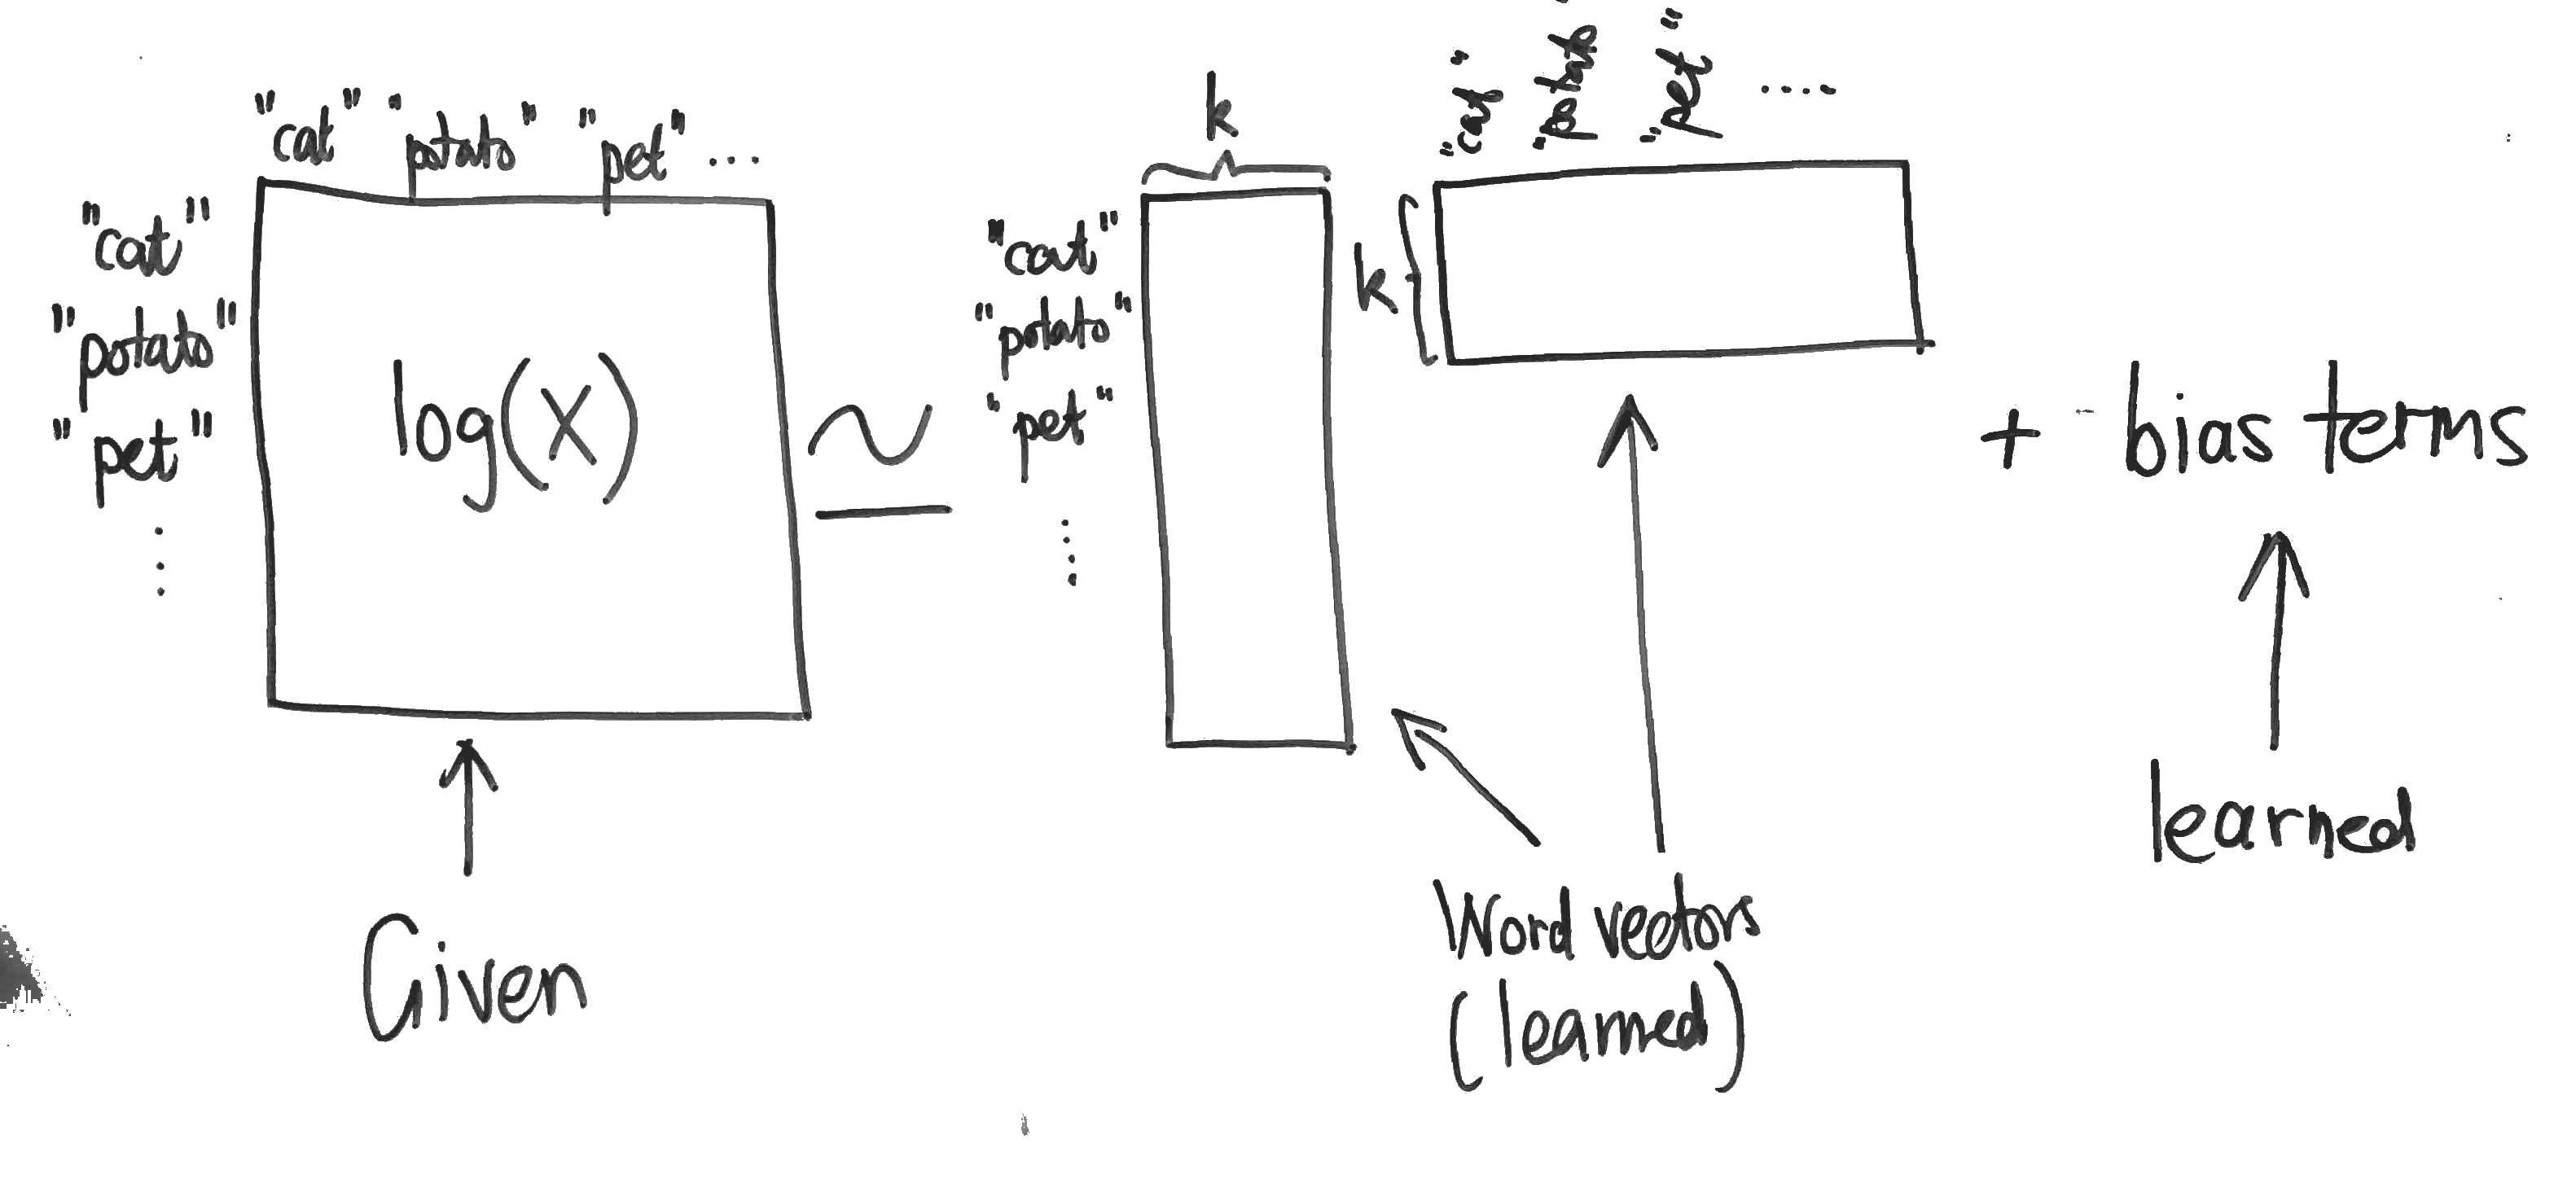

Чтобы реализовать всю эту красоту, потребуется алгоритм для матричной факторизации, а именно сингулярное разложение. [Очень хорошее объяснение](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf).

При работе с большими матрицами будет проблематично высчитать все собственные значения, поэтому как всегда в подобных случаях воспользуемся градиентным спуском. Функция потерь MSE.

In [ ]:
def svd_gradient_descent(A, k, learning_rate=0.001, epochs=100):
    """
    Параметры:
    A (numpy.ndarray): Входная матрица (m, n).
    k (int): Количество сингулярных значений для вычисления.
    learning_rate (float): Скорость обучения для градиентного спуска.
    epochs (int): Количество итераций для градиентного спуска.

    Возвращает:
    U (numpy.ndarray): Левые сингулярные векторы (m, k).
    V_T (numpy.ndarray): Правые сингулярные векторы (k, n).
    """

    m, n = A.shape
    np.random.seed(42)
    U = np.random.randn(m, k)
    V_T = np.random.randn(k, n)

    for epoch in range(epochs):
        A_hat = U @ V_T
        error = A - A_hat

        # Градиенты по U и V_T
        grad_U = -2 * error @ V_T.T
        grad_V_T = -2 * U.T @ error

        # Обновление
        U -= learning_rate * grad_U
        V_T -= learning_rate * grad_V_T

        # (Необязательно) Вывод ошибки каждые 10 эпох
        if epoch % 10 == 0 or epoch == epochs - 1:
            loss = np.mean((A - U @ V_T) ** 2)
            # print(f"Epoch {epoch}: MSE = {loss:.6f}")

    return U, V_T

In [ ]:
# Примеры - значения матрицы Result должны приближаться к значениям исходной матрицам

print('-' * 50)

A = np.array([[3, 1, 1],
              [-1, 3, 1]])

U, V_T = svd_gradient_descent(A, k=2, learning_rate=0.1)
print("U:\n", U)
print("V_T:\n", V_T)
print("Result:\n", U @ V_T)

print('-' * 50)

A2 = np.array([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]])

U2, V_T2 = svd_gradient_descent(A2, k=2, learning_rate=0.02, epochs=1000)
print("U2:\n", U2)
print("V_T2:\n", V_T2)
print("Result2:\n", U2 @ V_T2)

print('-' * 50)

--------------------------------------------------
U:
 [[ 1.51006432 -0.16032515]
 [ 0.16252052  1.80591831]]
V_T:
 [[ 1.90963377  0.83065866  0.71419022]
 [-0.72558912  1.58645101  0.48946258]]
Result:
 [[ 3.  1.  1.]
 [-1.  3.  1.]]
--------------------------------------------------
U2:
 [[0.63599262 1.39670824]
 [1.96380033 0.73392099]
 [3.29160804 0.07113374]]
V_T2:
 [[ 2.13212866  2.42332448  2.7145203 ]
 [-0.25489796  0.32847485  0.91184765]]
Result2:
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
--------------------------------------------------


Теперь реализуем сам алгоритм GloVe. Будем хранить матрицу со-встречаемости слов как разреженную матрицу (иначе не хватит оперативной памяти), а в качестве алгоритма для матричного разложения воспользуемся более оптимизированной, чем наша, версией "из коробки".

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix


def get_distinct_words(corpus):
    """
    Извлекает уникальные слова из текстов корпуса.

    Параметры:
        corpus (list): Список списков, где каждый внутренний список - токенизированный текст документа.

    Возвращает:
        tuple: Кортеж, содержащий:
            - list: Отсортированный список уникальных слов в корпусе.
            - int: Общее количество уникальных слов в корпусе.
    """
    word_set = set()
    for doc in corpus:
        word_set.update(doc)
    word_list = sorted(list(word_set))
    return word_list, len(word_list)


def compute_cooccurrence_matrix(corpus, window_size=1):
    """
    Вычисляет матрицу со-встречаемости для корпуса: сколько раз слова появляются рядом друг с другом в пределах window_size.

    Параметры:
        corpus (list): Список списков, где каждый внутренний список - токенизированный текст документа.
        window_size (int): Размер окна контекста для вычисления со-встречаемости (окно = центральное слово +- window_size).

    Возвращает:
        tuple: Кортеж, содержащий:
            - csr_matrix: Матрица cо-встречаемости, представленная как разреженная матрица.
            - dict: Словарь, сопоставляющий каждое слово его индексу в матрице.
    """
    words, n_words = get_distinct_words(corpus)
    word_to_id = {word: i for i, word in enumerate(words)}

    cooccurrence_counts = defaultdict(float) # Словарь для хранения счётчиков со-встречаемости: ключ — пара слов (по индексам), значение — взвешенное количество встреч

    for tokens in corpus:
        for idx, word in enumerate(tokens):
            word_id = word_to_id[word] # Находим окно контекскта
            start = max(0, idx - window_size)
            end = min(len(tokens), idx + window_size + 1)

            for i in range(start, end):
                if i != idx:
                    context_word = tokens[i]
                    context_id = word_to_id[context_word]
                    # Слова в окне получают вес, обратно пропорциональный расстоянию до центрального слова (ближе — важнее)
                    distance = abs(idx - i)
                    cooccurrence_counts[(word_id, context_id)] += 1.0 / distance

    rows, cols, data = [], [], [] # Формируем списки для создания разреженной матрицы
    for (word_id, context_id), count in cooccurrence_counts.items():
        rows.append(word_id)
        cols.append(context_id)
        data.append(count)

    cooc_matrix = csr_matrix((data, (rows, cols)), shape=(n_words, n_words))
    return cooc_matrix, word_to_id

def normalize(M):
    """
    Нормализует строки матрицы: превращает каждый вектор в единичный (длина = 1), чтобы можно было применять косинусное сходство.

    Параметры:
        M (numpy.ndarray): Матрица, которую нужно нормализовать.

    Возвращает:
        numpy.ndarray: Нормализованная матрица.
    """
    M_lengths = np.linalg.norm(M, axis=1)
    M_normalized = M / (M_lengths[:, np.newaxis] + 0.000001)  # сглаживание
    return M_normalized

In [ ]:
# Тесты

corpus = [["apple", "banana", "apple"], ["orange", "banana", "grape"]]
distinct_words, num_words = get_distinct_words(corpus)
assert distinct_words == ["apple", "banana", "grape", "orange"]
assert num_words == 4
print("get_distinct_words() works correctly!")

corpus = [["apple", "banana", "apple"], ["orange", "banana", "grape"]]
window_size = 1
M, word2ind = compute_cooccurrence_matrix(corpus, window_size)
expected_indices = {'apple': 0, 'banana': 1, 'grape': 2, 'orange': 3}
expected_matrix = [[0., 2., 0., 0.],
                    [2., 0., 1., 1.],
                    [0., 1., 0., 0.],
                    [0., 1., 0., 0.]]
assert word2ind == expected_indices
assert (M.toarray() == expected_matrix).all()
print("compute_cooccurrence_matrix() works correctly!")

get_distinct_words() works correctly!
compute_cooccurrence_matrix() works correctly!


У нас не слишком большое количество данных, тем не менее, модель чему-то выучивается. На всём массиве она обучается около 4 часов.

In [ ]:
# Уже обученная модель, чтобы не тратить время

!pip install --upgrade gdown
!gdown 1_-TnMejLJI78022kF2xDJo-bQgsCApL0
!gdown 1WHkeWrbxerj8HvAcemUuL4YwFbsiwSCj

Downloading...
From: https://drive.google.com/uc?id=1_-TnMejLJI78022kF2xDJo-bQgsCApL0
To: /content/cooccurrence_matrix.pickle
100% 11.3M/11.3M [00:00<00:00, 58.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WHkeWrbxerj8HvAcemUuL4YwFbsiwSCj
To: /content/word2ind.pickle
100% 1.28M/1.28M [00:00<00:00, 12.0MB/s]


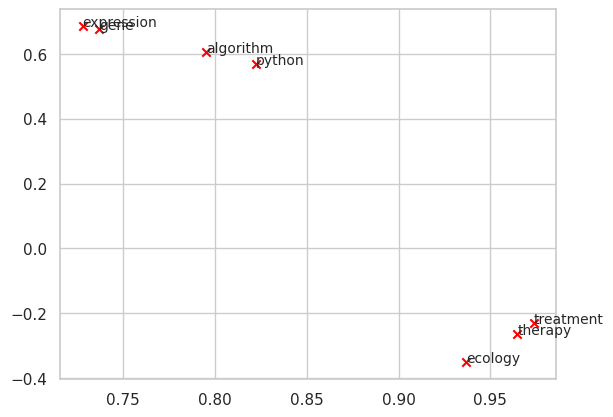

In [ ]:
import pickle

with open("/content/cooccurrence_matrix.pickle", "rb") as f:
    M = pickle.load(f)
with open("/content/word2ind.pickle", "rb") as f:
    word2ind = pickle.load(f)

M_reduced =  TruncatedSVD(n_components=2).fit_transform(M)
embeddings = normalize(M_reduced)

for word in ['algorithm', 'ecology', 'expression', 'gene', 'python', 'treatment', 'therapy']:
    word_index = word2ind[word]
    word_embedding = embeddings[word_index]
    x, y = word_embedding[0], word_embedding[1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, word, fontsize=10);

In [ ]:
len(word2ind)  # vocabulary size

82127

Функция `most_similar` для эмпирической оценки.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def most_similar(word, embeddings, word2ind, top_n=5):
    """
    Находит наиболее похожие на данное слово слова на основе косинусного сходства их векторных представлений.

    Параметры:
        word (str): Слово, для которого нужно найти похожие слова.
        embeddings (numpy.ndarray): Векторные представления слов.
        word2ind (dict): Словарь, сопоставляющий слова их индексам в матрице векторных представлений.
        top_n (int): Количество наиболее похожих слов для возврата.

    Возвращает:
        list: Список кортежей, содержащих наиболее похожие слова и их оценки косинусного сходства.
    """
    if word not in word2ind:
        raise ValueError(f"Слово '{word}' не найдено в словаре.")

    word_idx = word2ind[word]
    word_vector = embeddings[word_idx].reshape(1, -1) # Ищет вектор слова

    similarities = cosine_similarity(word_vector, embeddings)[0] # Вычисляем косинусное сходство между вектором слова и всеми остальными векторами

    # Убираем само слово из результатов
    similar_indices = similarities.argsort()[::-1] # индексы в порядке убывания сходства
    similar_words = []
    for idx in similar_indices:
        if idx != word_idx:
            similar_word = [w for w, i in word2ind.items() if i == idx][0]
            similar_words.append((similar_word, similarities[idx]))
        if len(similar_words) == top_n:
            break

    return similar_words

In [ ]:
M_reduced =  TruncatedSVD(n_components=312).fit_transform(M)
embeddings = normalize(M_reduced)

for word in ['algorithm', 'ecology', 'expression', 'gene', 'python', 'treatment']:
    print('-' * 50)
    print(word, end='\n\n')
    print(most_similar(word, embeddings, word2ind, top_n=10))

--------------------------------------------------
algorithm

[('method', np.float32(0.79358816)), ('approach', np.float32(0.7667201)), ('technique', np.float32(0.74953866)), ('procedure', np.float32(0.71772516)), ('scheme', np.float32(0.704085)), ('heuristic', np.float32(0.6915979)), ('formulation', np.float32(0.65546286)), ('unsupervised', np.float32(0.6192572)), ('model', np.float32(0.61400527)), ('idea', np.float32(0.61380166))]
--------------------------------------------------
ecology

[('diversity', np.float32(0.5677701)), ('industrial', np.float32(0.5665153)), ('environment', np.float32(0.55593204)), ('behaviour', np.float32(0.55206066)), ('transformation', np.float32(0.54376125)), ('resource', np.float32(0.52339935)), ('law', np.float32(0.52202123)), ('ecological', np.float32(0.5177009)), ('general', np.float32(0.51665336)), ('industry', np.float32(0.49557468))]
--------------------------------------------------
expression

[('proteincode', np.float32(0.966583)), ('atrophydete

Что-то дельное из этого можно получить.

Теперь взглянем на реализацию "из коробки".

In [ ]:
!pip uninstall numpy gensim -y
!pip install numpy==1.26.4
!pip install gensim --no-cache-dir --force-reinstall

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 195.9 MB/s eta 0:0

In [ ]:
import numpy as np

print(np.__version__)  # должно быть 1.26.4

1.26.4


In [ ]:
def load_embedding_model():
    """
    Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")  # есть и другие модели, см. gensim.downloader.info()['models'].keys()
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin


wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


In [ ]:
for word in ['algorithm', 'ecology', 'expression', 'gene', 'python', 'treatment']:
    print('-' * 50)
    print(word, end='\n\n')
    print(wv_from_bin.most_similar(word, 10))

--------------------------------------------------
algorithm

[('divide-and-conquer', 0.5534529089927673), ('krabat', 0.551224946975708), ('computes', 0.5506508946418762), ('jenalia.moreno@chron.com', 0.5458713173866272), ('fosterella', 0.5429463982582092), ('betterman', 0.540695071220398), ('starksia', 0.5393033623695374), ('algorithms', 0.5360755920410156), ('inugami', 0.5351618528366089), ('racinaea', 0.5292670130729675)]
--------------------------------------------------
ecology

[('icipe', 0.6646283864974976), ('zoogeography', 0.5999441742897034), ('ecofeminism', 0.5731804370880127), ('eco-systems', 0.546957790851593), ('energetics', 0.5300233364105225), ('palaeobiology', 0.5262896418571472), ('metapopulation', 0.5255571007728577), ('biogeochemistry', 0.5227234959602356), ('ecocriticism', 0.5164446234703064), ('afrofuturism', 0.5065551996231079)]
--------------------------------------------------
expression

[('sulf1', 0.6170405745506287), ('h19', 0.6167712211608887), ('dlc1', 0.6

что-то как-то очень плохо...

Поиграимся с полученными функциями.

1. Выберем какое-либо многозначное слово. Найдём его ближайших соседей.

2. Найдём тройку слов $(w_1,w_2,w_3)$ таких, что $w_1$ and $w_2$ синонимы, а $w_1$ и $w_3$ антонимы, но косинусное расстояние между первым и третьим меньше, чем между первым и вторым.

3. Выясним, есть ли в векторах предвзятость?

In [ ]:
from pprint import pprint

# 1
pprint(wv_from_bin.most_similar('key'))
print()

# 2
w1, w2, w3 = 'intelligent', 'smart', 'stupid'
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))
print()

# 3
A, B, C = 'woman', 'man', 'boss'
pprint(wv_from_bin.most_similar(positive=[A, C], negative=[B]))  # vector(woman) + vector(boss) - vector(man)
print('------------------------------------------------------')
pprint(wv_from_bin.most_similar(positive=[B, C], negative=[A]))  # vector(man) + vector(boss) - vector(woman)

[('crucial', 0.7789966464042664),
 ('important', 0.7257382869720459),
 ('vital', 0.6913551688194275),
 ('main', 0.6818131804466248),
 ('major', 0.6375277638435364),
 ('essential', 0.6215323209762573),
 ('point', 0.5916367769241333),
 ('leading', 0.5880058407783508),
 ('critical', 0.5788461565971375),
 ('one', 0.5786069631576538)]

Synonyms intelligent, smart have cosine distance: 0.31352531909942627
Antonyms intelligent, stupid have cosine distance: 0.6219476163387299

[('bosses', 0.5846002697944641),
 ('girlfriend', 0.5496258735656738),
 ('wife', 0.4893672466278076),
 ('mistress', 0.47348836064338684),
 ('boyfriend', 0.4683174192905426),
 ('tells', 0.46039488911628723),
 ('mother', 0.4581165313720703),
 ('daughter', 0.45619288086891174),
 ('lover', 0.4546445608139038),
 ('husband', 0.44650691747665405)]
------------------------------------------------------
[('bosses', 0.5625280737876892),
 ('manager', 0.5502104163169861),
 ('ferguson', 0.49866557121276855),
 ('arsene', 0.474548071622

1. Удивительно, но для такого базового слова, как *key* (в значении ключа, клавиши, кнопки, тональности), модель восприняла его только как прилагательное в значении *важный* (crutial, main, critical).

2. 'intelligent' = 'smart' != 'stupid'
  GloVe и аналогичные модели обучаются на статистике со-встречаемости, а не на смысле слов.
Антонимы часто встречаются в одних и тех же контекстах (например: "He is not intelligent, he is stupid.").
Это приводит к семантической близости в embedding-пространстве.

3. vector(woman) + vector(boss) - vector(man) = с какого-то перепугу только родственница (mother, wife, daughter) или любовница (mistress, lover, girlfriend). Как будто женщина не может быть шефом >:(
  
  Зато vector(man) + vector(boss) - vector(woman) = manager и много успешных фамилий и футбольных клубов.

  Осуждаю.




Применим модель "из коробки" к вашим данным из OpenAlex так же, как в предыдущих заданиях.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/openalex_preprocessed.csv")

In [ ]:
def get_mean_vector(wv, text):
    """ Возвращает усреднённый вектор по словам (если слово есть в wv). """
    words = text.split()
    valid_words = [word for word in words if word in wv]
    if not valid_words:
        return np.zeros(wv.vector_size)
    return np.mean([wv[word] for word in valid_words], axis=0)

df['vector'] = df['title_abstract_preprocessed'].apply(lambda x: get_mean_vector(wv_from_bin, x))

In [ ]:
df.head()

,id,title,abstract,domain,title_abstract,title_abstract_preprocessed,vector
0,https://openalex.org/W1775749144,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT,Since 1922 when Wu proposed the use of Folin p...,Life Sciences,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAG...,protein measurement folin phenol reagent since...,"[0.18249445, 0.25605315, 0.08871965, -0.048960..."
1,https://openalex.org/W2144634347,Molecular Cloning: A Laboratory Manual,Molecular Cloning has served as the foundation...,Life Sciences,Molecular Cloning: A Laboratory Manual Molecul...,molecular clone laboratory manual molecular cl...,"[0.07411627, 0.20687981, 0.07801256, -0.113983..."
2,https://openalex.org/W2179438025,Moderated estimation of fold change and disper...,In comparative high-throughput sequencing assa...,Life Sciences,Moderated estimation of fold change and disper...,moderated estimation fold change dispersion rn...,"[0.2598297, 0.13830408, 0.13131063, 0.026054, ..."
3,https://openalex.org/W2158714788,Gapped BLAST and PSI-BLAST: a new generation o...,The BLAST programs are widely used tools for s...,Life Sciences,Gapped BLAST and PSI-BLAST: a new generation o...,gap blast psiblast new generation protein data...,"[0.1666652, 0.21120948, 0.04007069, -0.1206125..."
4,https://openalex.org/W2106882534,CLUSTAL W: improving the sensitivity of progre...,The sensitivity of the commonly used progressi...,Life Sciences,CLUSTAL W: improving the sensitivity of progre...,clustal w improve sensitivity progressive mult...,"[0.19649008, 0.25264707, 0.0944551, 0.05640439..."


In [ ]:
df.to_csv("/content/drive/MyDrive/openalex_preprocessed_glove.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/openalex_preprocessed_glove.csv")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

--- Анализ схожести статей ---
Сравнение статьи: 'PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT...' (Life Sciences)

VS. 'INTEREST AND PRICES: FOUNDATIONS OF A THEORY OF MO...' (Social Sciences): 0.773
VS. 'Visual pattern recognition by moment invariants...' (Physical Sciences): 0.761
VS. 'Some Characteristics of Simple Types of Predation ...' (Health Sciences): 0.842

--- Кластерный анализ ---


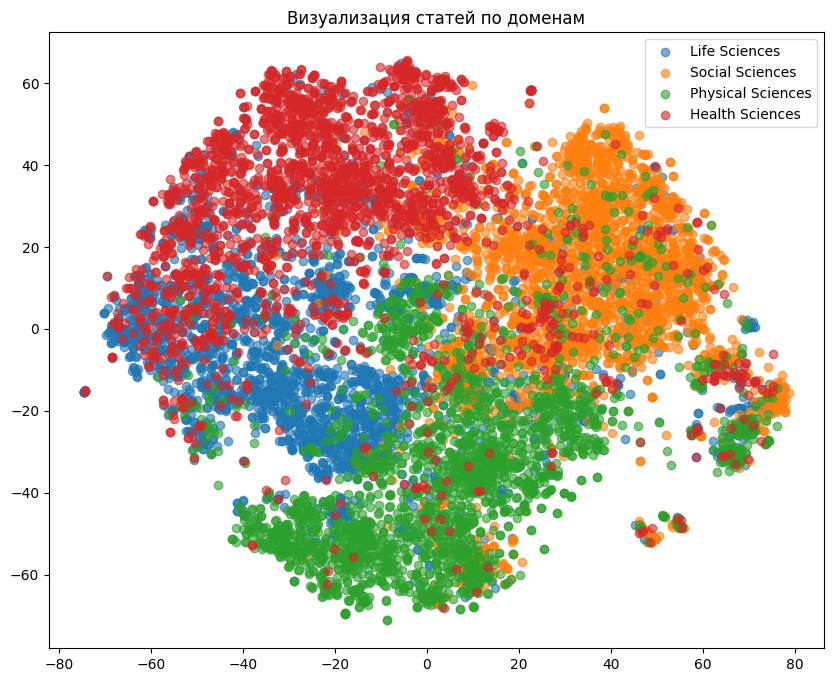


Соответствие доменов и кластеров:
cluster               0     1    2     3
domain                                  
Health Sciences     477  1403  465   155
Life Sciences       350   223  858  1069
Physical Sciences   604    18  117  1761
Social Sciences    2068    68   60   304


In [ ]:
def analyze_similarity(df, num_examples=3):
    vectors = np.array(df['vector'].tolist())

    # ищем самые похожие и самые разные статьи для выбранной
    first_article_vector = vectors[0]
    first_domain = df.iloc[0]['domain']

    print(f"Сравнение статьи: '{df.iloc[0]['title'][:50]}...' ({first_domain})\n")

    for domain in df['domain'].unique():
        if domain == first_domain:
            continue  # пропускаем статьи из того же домена

        other_articles = df[df['domain'] == domain]
        random_article = other_articles.sample(1).iloc[0]

        sim = cosine_similarity(
            [first_article_vector],
            [random_article['vector']]
        )[0][0]

        print(
            f"VS. '{random_article['title'][:50]}...' ({domain}): {sim:.3f}"
        )

def cluster_analysis(df):
    vectors = np.array(df['vector'].tolist())
    domains = df['domain'].unique()

    # k-means кластеризация
    kmeans = KMeans(n_clusters=len(domains), random_state=42)
    clusters = kmeans.fit_predict(vectors)

    # визуализация с t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    for domain in domains:
        mask = df['domain'] == domain
        plt.scatter(vectors_2d[mask, 0], vectors_2d[mask, 1], label=domain, alpha=0.6)

    plt.title('Визуализация статей по доменам')
    plt.legend()
    plt.show()

    df['cluster'] = clusters
    cross_tab = pd.crosstab(df['domain'], df['cluster'])
    print("\nСоответствие доменов и кластеров:")
    print(cross_tab)

print("--- Анализ схожести статей ---")
analyze_similarity(df)

print("\n--- Кластерный анализ ---")
cluster_analysis(df)

In [ ]:
def domain_keywords(glove, df, top_n=15):
    domain_vectors = {}
    for domain in df['domain'].unique():
        domain_texts = df[df['domain'] == domain]['title_abstract_preprocessed']
        full_text = ' '.join(domain_texts)
        domain_vectors[domain] = get_mean_vector(glove, full_text)

    print("\nХарактерные слова для доменов:")
    for domain, vector in domain_vectors.items():
        similar_words = glove.similar_by_vector(vector, topn=top_n)
        words = [word for word, _ in similar_words]
        print(f"{domain}: {', '.join(words)}")


print("--- Ключевые слова доменов ---")
domain_keywords(wv_from_bin, df)


--- Ключевые слова доменов ---

Характерные слова для доменов:
Life Sciences: example, particular, same, certain, this, these, can, rather, specific, that, therefore, instance, result, which, thus
Social Sciences: example, same, that, rather, this, particular, fact, not, because, well, should, what, even, need, only
Physical Sciences: example, same, this, rather, particular, that, can, instance, certain, these, means, only, which, use, given
Health Sciences: example, same, result, because, that, certain, only, this, particular, rather, not, given, need, can, well


Ситуация плачевная. Во всех доменных группах в топ-15 стоят исключительно общеупотребляемые слова, которые никак не наводят читателя или модель на нужный домен. Усреднённые векторы и модель GloVe не приспособлены к работе с научными статьями.

In [ ]:
X = np.array(df['vector'].tolist())
y = df['domain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
nb = MultinomialNB()
nb.fit(X_train, y_train)

ValueError: Negative values in data passed to MultinomialNB (input X).

GloVe-эмбеддинги - это не дискретные частоты, а непрерывные плотные векторы.

Наивный Байес предполагает, что признаки независимы и они — частоты появления токенов, то есть положительные значения (BOW, TF-IDF).

А у GloVe признаки — это вещественные значения, полученные из линейных комбинаций векторов. Они показывают близость слов к друг другу и могут выражаться отрицательными векторами.





In [ ]:
lsvc = LinearSVC(random_state=42)

lsvc.fit(X_train, y_train)

y_pred_svc = lsvc.predict(X_test)

print("=== LinearSVC ===")
print(classification_report(y_test, y_pred_svc))

=== LinearSVC ===
                   precision    recall  f1-score   support

  Health Sciences       0.82      0.75      0.78       481
    Life Sciences       0.77      0.72      0.75       486
Physical Sciences       0.81      0.83      0.82       544
  Social Sciences       0.79      0.89      0.83       489

         accuracy                           0.80      2000
        macro avg       0.80      0.80      0.80      2000
     weighted avg       0.80      0.80      0.80      2000



## Вааапрос

Так каким же образом записи получают метки, а также какое влияние это потенциально имеет на наш пайплайн классификации?

Что такое в нашем контексте feedback loop?

**Ответ цитатой из доки OpenAlex:**

OpenAlex Topics is a new system of topics and labels which can be used to accurately and succinctly describe what a paper is about. The new entity (Topics) ensures a one-to-one relationship between the topics and the higher levels of fields.

The subfields, fields, and domains are from Scopus’s ASJC structure. **Each topic (4516) will belong to one subfield (252), which will belong to one field (26), which will belong to one domain (4).**

OpenAlex used a **Large Language Model (LLM) to assign topics** to the most likely field and using that selection, the LLM then selected the most likely subfield. This allowed our team to efficiently connect the two separate pieces of data in a way that did not make someone go through over 4,000 topics and manually assign them to a subtopic.

Feedback loop - это явление, которое может искажать результаты этой лабораторной работы. Если метки влияют на дальнейшую обработку (в нашем случае - обучение моделей), а сами метки были предсказаны моделью, возникает feedback loop. Выводы следующих моделей (наших) будут неверными, если первая модель, которая назначила доменные метки, оказалась неправа.

